# Parse extended RNA fold output (incl. ensemble data)

In [1]:
from __future__ import division
%pylab inline
import seaborn as sns
sns.set_style('ticks')
sns.set_context('paper')
import glob
from scipy.stats import ks_2samp

def parse_rnafold_ensemble(fn,norm=False):
    """Parse raw RNAfold output (w/ ensemble) into dict.
    
    RNAfold output format:
    >seqname
    seq
    MFE structure (deltaG)
    ensemble structure ensemble free energy
    centroid
    mfe freq, ensmeble diversty
    
    Return : dict
    """
    
    def r2dict(n,s,ms,es,c,mdg,mf,edg,cdg,cd,dv):
        """Return a dictionary entry of the supplied RNAfold data"""
        return n[1:],{'seq':s,'mfe_struct':ms,'ensemble_struct':es,
                      'centroid_struct':c,'mfe_deltaG':mdg,
                      'mfe_freq':mf,'ensemble_deltaG':edg,
                      'diversity':dv,'centroid_deltaG':cdg,
                      'centroid_dist':cd}
    
    rdict = {}
    name = seq = mstruct = estruct = cstruct = None
    mdg = edg = cdg = dv = cd = None
    ctr = 0
    with open(fn,'r') as f:
        for line in f:
            line = line.rstrip()
            if '>' == line[0]:
                if name is not None:
                    name, d = r2dict(name,seq,mstruct,estruct,
                                     cstruct,mdg,mf,edg,cdg,cd,dv)
                    rdict[name] = d
                name = line
                ctr = 1
                continue
            
            line = line.split()
            if ctr == 1:
                seq = line[0]
            elif ctr == 2:
                mstruct = line[0]
                mdg = float(line[-1].strip('()').strip(' '))
            elif ctr == 3:
                estruct = line[0]
            elif ctr == 4:
                edg = float(line[-2])
            elif ctr == 5:
                cstruct = line[0]
                cdg = float(line[-2].strip('{}'))
                cd = float(line[-1].strip('d={}'))
            elif ctr == 6:
                mf = float(line[6].strip(';'))
                dv = float(line[-1])
            
            ctr +=1
    
    # Get the straggler
    try:
        name, d = r2dict(name,seq,mstruct,estruct,cstruct,mdg,mf,edg,
                         cdg,cd,dv)
        rdict[name] = d
    except:
        pass
    
    if norm:
        for name in rdict.iterkeys():
            L = len(rdict[name]['seq'])
            rdict[name]['mfe_deltaG'] /= L
            rdict[name]['ensemble_deltaG'] /=L
            rdict[name]['centroid_deltaG'] /=L
    
    return rdict

def parse_lfold(fn,maxlen=100):
    name = None
    data = {}
    with open(fn,'r') as f:
        for line in f:
            line = line.strip()
            if '>' in line:
                name = line[1:]
                if name is not None:
                    data[name] = {}
                grabnext = False
                continue
            if 'A' in line and 'C' in line and 'G' in line and 'T' in line:
                grabnext= True
                data[name]['len'] = len(line.rstrip())
                continue
            if grabnext:
                data[name]['deltaG'] = float(line.rstrip().strip('()'))
                data[name]['deltaG'] /= data[name]['len']
                grabnext=False
                continue
                
            line = line.split()
            try:
                pos = int(line[-1])-1
                val = float(line[-2].strip('()'))
                plen = len(line[0])
                if plen > maxlen:
                    continue
                for i in range(plen):
                    if i+pos in data[name]:
                        v = data[name][i+pos]
                    else:
                        v = 0
                    data[name][i+pos] = min(v,val)
#                     data[name][i+pos] = v+val
            except:
                pass
    return data

def lfold2arr(ldict):
    arr = np.zeros(np.max(ldict.keys())+1)
    
    for pos in ldict.keys():
        arr[pos] = ldict[pos]
    return arr

def movingaverage (values, window):
    weights = np.repeat(1.0, window)/window
    sma = np.convolve(values, weights, 'valid')
    return sma

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = []
names = []
# fns = ['yeast/sc2.cen.rnafold.txt','yeast/high_loss_cde2.rnafold.txt',
fns = ['../data/rnafold/yeast/sc2.cen.rnafold.txt',
       '../data/rnafold/yeast/smik.cen.rnafold.txt',
       '../data/rnafold/yeast/skud.cen.rnafold.txt',
       '../data/rnafold/yeast/n_dairenensis.rnafold.txt',
       '../data/rnafold/yeast/n_castelli.rnafold.txt']


ns = [r"$\it{S. cerevisiae}$",r'$\it{S. mikatae}$',r'$\it{S. kudriavzevii}$',
      r'$\it{S. diarenensis}$',r'$\it{S. castellii}$']
spec_data = []

for fn,nss in zip(fns,ns):
# for fn in glob.glob('yeast/*rnafold.txt'):
    d = parse_rnafold_ensemble(fn)
    x = [d[name]['ensemble_deltaG'] for name in d.keys()]
    data.extend(x)
    names.extend([nss]*len(x))
    spec_data.append(x)

In [ ]:
corr = np.ones((len(spec_data),len(spec_data)))

for i,d1 in enumerate(spec_data):
    for j,d2 in enumerate(spec_data):
        s,p = ks_2samp(d1,d2)
        corr[i,j] = p
fig, (ax, cax) = plt.subplots(nrows=2,figsize=(3,3.5), 
                  gridspec_kw={"height_ratios":[1, 0.1]})

im = ax.imshow(corr,cmap=cm.RdBu,
               rasterized=True,norm=matplotlib.colors.LogNorm(vmin=1e-3,vmax=1))
ax.vlines([2.5],-0.5,4.5,linestyles='dotted',lw=2)
ax.hlines([2.5],-0.5,4.5,linestyles='dotted',lw=2)


ax.set_xticks([])
ax.set_yticks([])
fig.colorbar(im, cax=cax,extend='both',orientation="horizontal")
setp(cax.get_xticklabels(),size=16)
cax.set_xlabel('Kolmogorov-Smirnov p-value',size=16)

plt.savefig('../figures/ks_pvalue_yeast.svg')

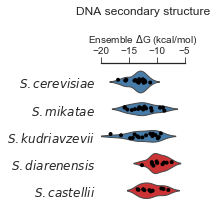

In [32]:
plt.figure(figsize=(1.5,2.5))

# cols = ['#e41a1c','#377eb8','#e41a1c','#e41a1c','#377eb8','#377eb8']
cols = ['#377eb8','#377eb8','#377eb8','#e41a1c','#e41a1c']


# cols = ['#fb9a99','#a6cee3','#fb9a99','#fb9a99','#a6cee3','#a6cee3']
ax = sns.violinplot(x=data,y=names, color=None,
                 width=0.8,linewidth=1,palette=cols,bw=0.5,inner=None)
sns.stripplot(x=data,y=names,
              jitter=True, size=4, color="black", linewidth=0,marker='o')

ax.set_xticks([-20,-15,-10,-5])
# ax.set_xticklabels([-20,-11,-4],size=14)
ax.set_xlim([-20,-5])

# ax.set_yticklabels(['Native','High loss','Low loss'],size=14)
ax.tick_params(axis='y',length=0)
ax.xaxis.tick_top()
setp(ax.get_yticklabels(),size=12)
sns.despine(ax=ax,left=True,trim=False,top=False,bottom=True,offset=5)
ax.set_title('DNA secondary structure',y=1.35,size=12)
ax.xaxis.set_label_position('top')
setp(ax.get_xticklabels(),size=10,y=0.97)
ax.set_xlabel('Ensemble '+r'$\Delta$'+'G (kcal/mol)',size=10)


plt.savefig('../figures/yeast_cen_loss.svg')

In [ ]:
data = []
names = []
fns = ['../data/rnafold/homo_sapiens.2500.rnafold.txt',
       '../data/rnafold/pan_troglodytes.2500.rnafold.txt',
       '../data/rnafold/pan_paniscus.2500.rnafold.txt',
       '../data/rnafold/gorilla_gorilla.2500.rnafold.txt',
       '../data/rnafold/gorilla_berengei.2500.rnafold.txt',
       '../data/rnafold/pongo_abelii.2500.rnafold.txt',
       '../data/rnafold/pongo_pygmaeus.2500.rnafold.txt',
       '../data/rnafold/chlorocebus_aethiops.2500.rnafold.txt',
       '../data/rnafold/chlorocebus_sabaeus.2500.rnafold.txt',
       '../data/rnafold/chlorocebus_pygerythrus.2500.rnafold.txt',
       '../data/rnafold/macaca_mulatta.2500.rnafold.txt',
       '../data/rnafold/macaca_fascicularis.2500.rnafold.txt',
       '../data/rnafold/papio_anubis.2500.rnafold.txt',
       '../data/rnafold/misat.sample.rnafold.txt',
       '../data/rnafold/chicken_unique_cen.sim_reads_art.rnafold.txt']

spec_data = []

for fn in fns:
    print fn
    d = parse_rnafold_ensemble(fn)
#     x = [d[name]['ensemble_deltaG'] for name in d.keys()]
#     x = [d[name]['mfe_freq'] for name in d.keys()]
    x = [100*d[name]['ensemble_deltaG']/len(d[name]['seq']) for name in d.keys()]

    data.extend(x)
    names.extend([fn]*len(x))
    
    spec_data.append(np.random.choice(x,size=100))

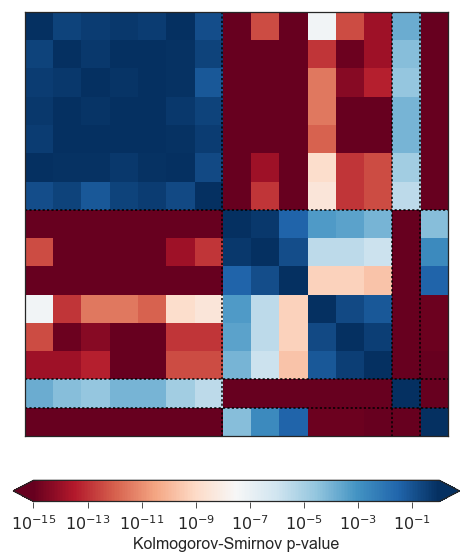

In [12]:
corr = np.ones((len(spec_data),len(spec_data)))

for i,d1 in enumerate(spec_data):
    for j,d2 in enumerate(spec_data):
        s,p = ks_2samp(d1,d2)
        corr[i,j] = p
fig, (ax, cax) = plt.subplots(nrows=2,figsize=(8,9), 
                  gridspec_kw={"height_ratios":[1, 0.05]})

im = ax.imshow(corr,cmap=cm.RdBu,norm=matplotlib.colors.LogNorm(vmin=1e-15,vmax=1),
               rasterized=True)
# ax.vlines([6.5,10.5,17.5],-0.5,21.5,linestyles='dotted',lw=1.25)
# ax.hlines([6.5,10.5,17.5],-0.5,21.5,linestyles='dotted',lw=1.25)

ax.vlines([6.5],-0.5,14.5,linestyles='dotted',lw=1.5)
ax.vlines([12.5],-0.5,14.5,linestyles='dotted',lw=1.5)
ax.vlines([13.5],-0.5,14.5,linestyles='dotted',lw=1.5)
ax.hlines([6.5],-0.5,14.5,linestyles='dotted',lw=1.5)
ax.hlines([12.5],-0.5,14.5,linestyles='dotted',lw=1.5)
ax.hlines([13.5],-0.5,14.5,linestyles='dotted',lw=1.5)

ax.set_xticks([])
ax.set_yticks([])
fig.colorbar(im, cax=cax,extend='both',orientation="horizontal")
setp(cax.get_xticklabels(),size=16)
cax.set_xlabel('Kolmogorov-Smirnov p-value',size=16)

plt.savefig('../figures/ks_pvalue_multispecies.svg')

def hex2rgb(h):
    h = h.strip('#')
    return tuple([int(h[i:i+2], 16)/255 for i in (0, 2 ,4)]+[1])


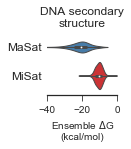

In [29]:
plt.figure(figsize(1.25,1.05))

cols = ['#377eb8','#e41a1c']
# cols = ['#a6cee3','#fb9a99']

ax = sns.violinplot(x=(misat+masat)[::-1],y=names[::-1], palette=cols,notch=True,
                 width=0.95,linewidth=1,bw=0.4)
setp(ax.get_yticklabels(),size=12)
ax.tick_params(axis='y',length=0)
ax.set_xlabel('Ensemble '+r'$\Delta$'+'G\n(kcal/mol)',size=10)
ax.set_xlim([-40,0])
sns.despine(ax=ax,left=True,bottom=False,trim=True,offset=5)
ax.set_xticks([0,-20,-40])
setp(ax.get_yticklabels(),size=12)
setp(ax.get_xticklabels(),size=10)




ax.set_title('DNA secondary\nstructure',size=12)

plt.savefig('../figures/mouse.rnafold.svg')

In [ ]:
bins = np.linspace(-20,-5,15)
# bins = np.linspace(0,40,20)
data = []
names = []
fns = [
       '../data/rnafold/homo_sapiens.2500.rnafold.txt',
       '../data/rnafold/pan_troglodytes.2500.rnafold.txt',
       '../data/rnafold/pan_paniscus.2500.rnafold.txt',
       '../data/rnafold/gorilla_gorilla.2500.rnafold.txt',
       '../data/rnafold/gorilla_berengei.2500.rnafold.txt',
       '../data/rnafold/pongo_abelii.2500.rnafold.txt',
       '../data/rnafold/pongo_pygmaeus.2500.rnafold.txt',
       '../data/rnafold/chlorocebus_aethiops.2500.rnafold.txt',
       '../data/rnafold/chlorocebus_sabaeus.2500.rnafold.txt',
       '../data/rnafold/chlorocebus_pygerythrus.2500.rnafold.txt',
       '../data/rnafold/macaca_mulatta.2500.rnafold.txt',
       '../data/rnafold/macaca_fascicularis.2500.rnafold.txt',
       '../data/rnafold/papio_anubis.2500.rnafold.txt',
       '../data/rnafold/misat.sample.1000.rnafold.txt',
       '../data/rnafold/equus_caballus.2500.rnafold.txt',
       '../data/rnafold/chicken_unique_cen.sim_reads_art.rnafold.txt',
        '../data/rnafold/stickleback.rnafold.txt',
       '../data/rnafold/pombe.cen_core.sim_reads.rnafold.txt',
       '../data/rnafold/oryza_sativa.2500.rnafold.txt',
        '../data/rnafold/zea_mays.2500.rnafold.txt',
        '../data/rnafold/arabidopsis_thaliana.2500_sim.rnafold.txt'
      ]

for fn in fns:
    print fn
    d = parse_rnafold_ensemble(fn)
    x = [100*d[name]['ensemble_deltaG']/len(d[name]['seq']) for name in d.keys()]
    
    hgram,_ = np.histogram(x,bins=bins,normed=True)
    
    data.append(hgram)
    names.append(fn)

# data = np.array(data)

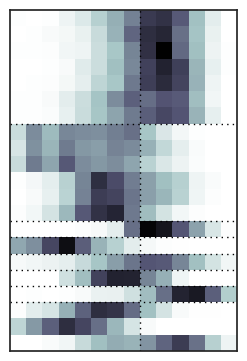

In [242]:
# data
imshow(data,cmap=cm.bone_r,interpolation='none',rasterized=True)
plt.axhline(y=6.5,lw=1,c='black',ls='dotted')
plt.axhline(y=12.5,lw=1,c='black',ls='dotted')
plt.axhline(y=13.5,lw=1,c='black',ls='dotted')
plt.axhline(y=14.5,lw=1,c='black',ls='dotted')
plt.axhline(y=15.5,lw=1,c='black',ls='dotted')
plt.axhline(y=16.5,lw=1,c='black',ls='dotted')
plt.axhline(y=17.5,lw=1,c='black',ls='dotted')
plt.axvline(x=7.5,lw=1,c='black',ls='dotted')
plt.xticks([])
plt.yticks([])

plt.savefig('../figures/rnafold.heatmap.svg')

In [3]:
fns = glob.glob('../data/rnafold/human_hors/*.sim.rnafold.txt')


data = []
names = []

spec_data = []

for fn in fns:
    print fn
    d = parse_rnafold_ensemble(fn)
#     x = [d[name]['ensemble_deltaG'] for name in d.keys()]
#     x = [d[name]['mfe_freq'] for name in d.keys()]
    x = [100*d[name]['ensemble_deltaG']/len(d[name]['seq']) for name in d.keys()]

    data.extend(x)
    names.extend([fn]*len(x))
    

    spec_data.append(np.random.choice(x,size=50))

../data/rnafold/human_hors/D7Z1.monomers.sim.rnafold.txt
../data/rnafold/human_hors/D19Z1.monomers.sim.rnafold.txt
../data/rnafold/human_hors/Xmono.monomers.sim.rnafold.txt
../data/rnafold/human_hors/D17Z1B.monomers.sim.rnafold.txt
../data/rnafold/human_hors/DXZ1.monomers.sim.rnafold.txt
../data/rnafold/human_hors/D5Z2.monomers.sim.rnafold.txt
../data/rnafold/human_hors/RP3.monomers.sim.rnafold.txt
../data/rnafold/human_hors/D11Z1.monomers.sim.rnafold.txt
../data/rnafold/human_hors/D7Z2.monomers.sim.rnafold.txt
../data/rnafold/human_hors/D4Z2bn.monomers.sim.rnafold.txt
../data/rnafold/human_hors/D5Z1.monomers.sim.rnafold.txt
../data/rnafold/human_hors/3mono.monomers.sim.rnafold.txt
../data/rnafold/human_hors/DYZ3.monomers.sim.rnafold.txt
../data/rnafold/human_hors/chrUnplaced_BAC2.monomers.sim.rnafold.txt


In [ ]:
bins = np.linspace(-25,-5,15)

data = []
names = []



fns = ['../data/rnafold/human_hors/D5Z2.monomers.sim.rnafold.txt',
       '../data/rnafold/human_hors/DXZ1.monomers.sim.rnafold.txt',
       '../data/rnafold/human_hors/D7Z1.monomers.sim.rnafold.txt',
      '../data/rnafold/human_hors/DYZ3.monomers.sim.rnafold.txt',
      '../data/rnafold/human_hors/D17Z1B.monomers.sim.rnafold.txt',
      '../data/rnafold/human_hors/D11Z1.monomers.sim.rnafold.txt',
        '../data/rnafold/human_hors/D7Z2.monomers.sim.rnafold.txt',
       '../data/rnafold/human_hors/D4Z2bn.monomers.sim.rnafold.txt',
      '../data/rnafold/human_hors/D19Z1.monomers.sim.rnafold.txt',
      '../data/rnafold/human_hors/Xmono.monomers.sim.rnafold.txt',
      '../data/rnafold/human_hors/3mono.monomers.sim.rnafold.txt',
      '../data/rnafold/human_hors/D5Z1.monomers.sim.rnafold.txt']


for fn in fns:
    print fn
    d = parse_rnafold_ensemble(fn)
    x = [100*d[name]['ensemble_deltaG']/len(d[name]['seq']) for name in d.keys()]
    
    hgram,_ = np.histogram(x,bins=bins,normed=True)
    
    data.append(hgram)
    names.append(fn)

In [ ]:
plt.figure(figsize=(4,4))

species = ['D5Z2','DXZ1','D7Z1','DYZ3','D171B','D11Z1','D7Z2','D4Z2bn','D19Z1','Xmono','3mono','D5Z1']
cols = ['blue']*len(species)
cols = ['#e41a1c']*4 + ['#377eb8']*4 + ['grey']*4#,'grey'] + ['#6a3d9a'] + ['#4daf4a']


# cols = ['#fb9a99']*11 + ['#a6cee3']*7 + ['#e5d8bd']*4
ax = sns.violinplot(x=data,y=names, palette=cols,notch=False,
                 width=0.8,linewidth=1,bw=0.5,gridsize=50,inner='box',scale='width',cut=0)
# ax = sns.boxplot(x=data,y=names, color=None,notch=True,
#                  width=0.5,linewidth=1,whis=0.5,fliersize=0)
sns.stripplot(x=data,y=names,
              jitter=True, size=4, color="black", linewidth=0,marker='o')

# ax.set_xticks([-20,-11,-4])
# ax.set_xticklabels([-20,-11,-4],size=14)
# ax.set_xlim([-20,-4])

# ax.set_yticklabels(['Native','High loss','Low loss'],size=14)
ax.set_title('Ensemble '+r'$\Delta$'+'G (kcal/mol)',size=10)
ax.tick_params(axis='y',length=0)
ax.xaxis.tick_top()
ax.set_yticklabels(species)
setp(ax.get_yticklabels(),size=10)
setp(ax.get_xticklabels(),size=10)
ax.set_xlim(-30,-5)
# ax.set_xticks([-20,-10,0])
# ax.set_xticklabels(['','-20','','-10','','0'])
ax.grid(axis='x',ls='dotted')
sns.despine(ax=ax,left=True,trim=True,top=False,bottom=True)
# plt.savefig('../figures/human_hors.svg')

([], <a list of 0 Text yticklabel objects>)

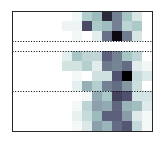

In [6]:
plt.figure(figsize=(2.5,4))
imshow(data,cmap=cm.bone_r,interpolation='none',rasterized=True)
plt.axhline(y=2.5,lw=1,c='black',ls='dotted')
plt.axhline(y=3.5,lw=1,c='black',ls='dotted')
plt.axhline(y=7.5,lw=1,c='black',ls='dotted')


plt.xticks([])
plt.yticks([])

plt.savefig('../figures/hors.rnafold.heatmap.svg')
